In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import Literal,Optional
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
import operator

load_dotenv()

True

# step:1) defining Model objects.

In [2]:
#Groq Model object
model1 = ChatGroq(
    model="groq/compound-mini",
    temperature=0.2
)
model1

#openAI model object.
model2 = ChatOpenAI(temperature=0.2)

## Hugging Face endpoint define karo OPen source Model chat or Generation Model.
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model3 = ChatHuggingFace(llm=llm)

# step:2) defining the state or memory class based on workflow using TypedDict futhure we can create stategraph object

In [3]:
class TweetState(TypedDict):
    topic:str
    tweet :str | None                      #to store the generated tweet based on topic.
    evaluation : Literal["approved","not_approved"] | None
    feedback : str | None                  #after evaluating giving feedback
    iteration : int | None                 #no of iteration counting
    max_iteration : int | None             #infinite loop ko break karne ke liye we used this.
    
    #reducers key defining
    feedback_history : Annotated[List[str],operator.add]
    tweet_history : Annotated[List[str],operator.add]
    

In [4]:
#creating a graph object by using graphstate class.
graph = StateGraph(TweetState)
graph

# defining parsers

In [5]:
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
parser = StrOutputParser()

In [6]:
#creating Generate_Tweet nodes by using function and performing action over task and updating state returning back updated state.
def Generate_Tweet(state:TweetState) ->TweetState:
    #fetching the field from the state class.
    topic = state['topic']
    
    #based on this topic using LLM they are generating tweet by using Prompt template changing them into Structured Instruction Prompt.
    messages = [
        SystemMessage(content="You are Funny and clever Twitter/X social media content creator"),
        HumanMessage(content=f"""
                     Write a short,original,and hiarious tweet on this topic:{topic}
                     
                     Task:
                        1. Write a short and engaging tweet about the given topic.  
                        2. Keep it under 280 characters.  
                        3. Use simple, catchy, funny language.  
                        4. Add 1-2 relevant hashtags.  
                        5. Do not use question-answer format.
                        6. Think in meme logic,punchlines or relatable takes.
                        7. use simple day to day english Language.

                     
                    Return the response in this format:
                  """)
        
    ]
    
    #passing this prompt to llm using sequential chain is runnable.
    response = model3.invoke(messages)
    
    content = response.content
    
    #updating the content to state memory returning partial updated state.
    return {
        'tweet':content,
        'tweet_history' :[content]
        
    }
    

In [7]:
# Creating a Pydantic class to structure evaluation results
class EvaluationSchema(BaseModel):
    eval: Annotated[
        Literal["approved", "not_approved"],
        Field(..., description="Final evaluation result: choose either 'approved' or 'not_approved'.")
    ]
    
    feedback: Annotated[
        str,
        Field(..., description="Provide constructive feedback explaining the strengths and weekness about the tweet after evaluation.")
    ]
    
pydan_parser  = PydanticOutputParser(pydantic_object=EvaluationSchema)
pydan_parser

PydanticOutputParser(pydantic_object=<class '__main__.EvaluationSchema'>)

In [8]:
#creating Generate_Tweet nodes by using function and performing action over task and updating state returning back updated state.
def Evaluate_Generated_Tweet(state:TweetState) ->TweetState:
    #fetching the field or key from state class.
    tweet= state['tweet']
    
    #creating structure instruction template
    eval_prompt = PromptTemplate(
        template="""
            You are a social media content evaluator.  
            Your task is to analyze the given tweet based on the following **Evaluation Criteria**:
            
            Evaluation Criteria:
            - **Originality** – Is this fresh, or overused?
            - **Humor** – Does it make people smile or laugh?
            - **Punchiness** – Is it short, sharp, and scroll-stopping?
            - **Virality Potential** – Could people share/retweet it widely?
            - **Format** – Is it a valid tweet (well-formed, under 280 characters)?

            Tweet: {tweet}

            Return your evaluation strictly in the following JSON format:

            {format_instructions}
            """,
            input_variables=['tweet'],
            partial_variables={'format_instructions':pydan_parser.get_format_instructions()}
    )
    
    #passing them to llm model so forming sequnetial chains.
    chain = eval_prompt | model2 | pydan_parser
    
    #now invoking chain.
    result = chain.invoke({'tweet':tweet})
    
    #updating them in state memory.
    return {
        'feedback': result.feedback,
        'evaluation':result.eval,
        'feedback_history' : [result.feedback]
    }

In [9]:
#creating Optimizing_Tweet node by using function and performing action init.
def Optimizing_Tweet(state:TweetState) -> TweetState:
    #fetching the fielsd from satet class.
    feedback = state['feedback']
    evaluation = state['evaluation']
    tweet  = state['tweet']
    topic = state['topic']
    
    #creating a prompt structure instruction template
      # structured prompt template
    prompt = PromptTemplate(
        template="""
            You are a professional social media strategist.  
            A tweet was generated on the topic: **{topic}**  

            Here is the original tweet:  
            "{tweet}"  

            Evaluation result: **{evaluation}**  
            Evaluator feedback: "{feedback}"  

            Your task:
            - Improve or optimize the tweet while keeping it under 280 characters.  
            - Apply the feedback to make it better (original, punchy, shareable).  
            - Keep the tone engaging and clear.  

            Return the final optimized tweet only in this format:  
            Optimized_Tweet: ...
            """,
                    input_variables=["topic", "tweet", "evaluation", "feedback"],
        )
    
    #passing them to llm model so forming sequnetial chains.
    chain = prompt | model2 | parser
    
    #now invoking chain.
    result = chain.invoke({"topic":topic, "tweet":tweet, "evaluation":evaluation, "feedback":feedback})
    
    #updating them in state memory.
    new_iteration_value = state['iteration'] + 1
    
    return {
        'tweet':result,#result["Optimized_Tweet"]
        'iteration':new_iteration_value,
        'tweet_history':[result]
    }
    

# helper function that route the condition by edges

In [10]:
def checkpoint_condition(state:TweetState) :
    #fetching field from state class.
    eval = state['evaluation']
    iter = state['iteration']
    
    if eval == "approved" or iter >= max(state['max_iteration']) :
        return "approved"
    else:
        return 'Optimizing_Tweet'

# step:3) adding nodes or edges to graph

In [11]:
#adding nodes to graph (in nodes we define task and action init by passing state memory)
graph.add_node(node="Generate_Tweet",action=Generate_Tweet)
graph.add_node(node="Evaluate_Generated_Tweet",action=Evaluate_Generated_Tweet)
graph.add_node(node="Optimizing_Tweet",action=Optimizing_Tweet)


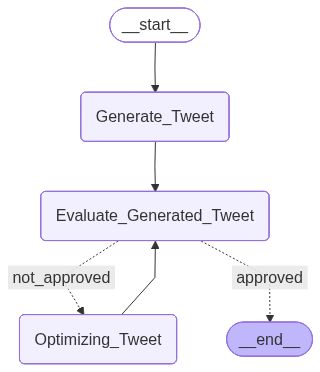

In [12]:
#adding edges to nodes.
graph.add_edge(START,'Generate_Tweet')
graph.add_edge('Generate_Tweet','Evaluate_Generated_Tweet')

#conditional edges.
graph.add_conditional_edges('Evaluate_Generated_Tweet',checkpoint_condition,{'approved':END,"not_approved":"Optimizing_Tweet"})

#loop edges(just manupulating the edges.).
graph.add_edge('Optimizing_Tweet','Evaluate_Generated_Tweet')

graph.compile()

In [21]:
#compiling the workflow.
workflow = graph.compile()


#now passing the initial state to start nodes mei.
initial_state = TweetState(topic="Nirmala Sitaraman",max_iteration=5,iteration=1)
initial_state

{'topic': 'Nirmala Sitaraman', 'max_iteration': 5, 'iteration': 1}

In [22]:
#passing this inital state through out workflow and sharing memory to each nodes edges
result = workflow.invoke(initial_state)
result

{'topic': 'Nirmala Sitaraman',
 'tweet': ' "Nirmala Sitaraman just announced a new policy: From now on, every Indian will get a free \'Chai-walla\' license. Because who doesn\'t need a cup of chai to handle the daily \'desh ki baat\'? #NirmalaSitaraman #ChaiWallaLicense"',
 'evaluation': 'approved',
 'feedback': "The tweet scores well on originality by combining a current event with a humorous twist. The mention of 'Chai-walla' license adds a relatable and funny element. The tweet is punchy and likely to catch people's attention while scrolling. It has the potential to go viral due to its humor and relevance to everyday life in India. The format is valid with proper use of hashtags and within the character limit.",
 'iteration': 1,
 'max_iteration': 5,
 'feedback_history': ["The tweet scores well on originality by combining a current event with a humorous twist. The mention of 'Chai-walla' license adds a relatable and funny element. The tweet is punchy and likely to catch people's atte